# `003` Backpropagation

Requirements: 001 Derivatives.

Backpropagation is the process of calculating the gradients of a function with respect to its parameters, a.k.a. finding their partial derivatives. This basically tells us how much each parameter affects the final result. This is the key to train neural networks, as we need to know how much each weight affects the final result in order to adjust them properly.

Let's consider the following equation:

$$f(x, y, z, w) = x * (y + z * w)$$

And let's say the initial values for $(x, y, z, w)$ are $(2,3,-1,7)$. We could use graphviz to paint the formula like this:

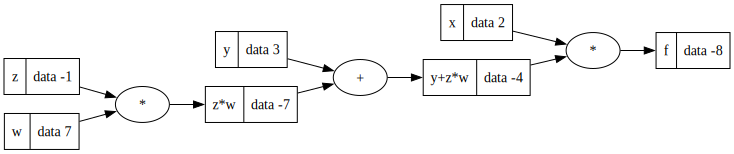

In [1]:
from graphviz import Digraph

d = Digraph(graph_attr={'rankdir': 'LR'})
d.node('x', '{x | data 2}', shape='record')
d.node('y', '{y | data 3}', shape='record')
d.node('z', '{z | data -1}', shape='record')
d.node('w', '{w | data 7}', shape='record')
d.node('z*w', '{z*w | data -7}', shape='record')
d.node('y+z*w', '{y+z*w | data -4}', shape='record')
d.node('f', '{f | data -8}', shape='record')
d.node('+', '+')
d.node('*1', '*')
d.node('*2', '*')
d.edges([('z', '*1'), ('w', '*1'), ('*1', 'z*w'), ('y', '+'), ('z*w', '+'), ('+', 'y+z*w'), ('x', '*2'), ('y+z*w', '*2'), ('*2', 'f')])
d

The process of navigating through this tree of numbers to obtain the final result is called the forward pass.

Now, we need to know how each individual node in that tree contributes to the final value of f, and we do this from the final node doing a backward pass, which is why it is called backpropagation.

Going node by node:
* For the final node $f$, the gradient is always 1. This is because the final value is the final value, and increasing it by 1 will increase the final value by 1.
* Then, we have a `*` node, which multiplies the values of $x$ and $(y + z * w)$. If we increase $x$ by 1, the final value will increase by $(y + z * w)$, which is -4. If we increase $(y + z * w)$ by 1, the final value will increase by $x$, which is 2. Hence, the gradient for $x$ is $(y + z * w)$, and the gradient for $(y + z * w)$ is $x$. We can see the multiplication node as a gradient-swapper.
* Then, we have a `+` node, which adds the values of $y$ and $(z * w)$. If we increase any of the two terms of $y + (z * w)$ by 1, the value of such equation will increase by 1. And since the gradient of that equation is $2$, we have to multiply the gradient of the `+` node by 2. Hence, the gradient for $y$ is 2, and the gradient for $(z * w)$ is 2. We can see the addition node as a gradient-distributor.
* Finally, we have another `*` node, which multiplies the values of $z$ and $w$. We know that `*` is a gradient-swapper, so the gradient for $z$ is $w$, and the gradient for $w$ is $z$. But again, due to the chain rule, we have to multiply those gradients by the parent gradient, which is 2. Hence, the gradient for $z$ is $2w=14$, and the gradient for $w$ is $2z=-2$.

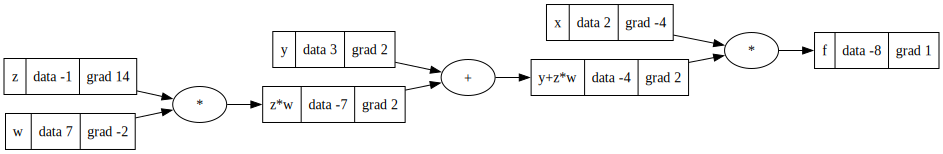

In [2]:
from graphviz import Digraph

d = Digraph(graph_attr={'rankdir': 'LR'})
d.node('x', '{x | data 2 | grad -4}', shape='record')
d.node('y', '{y | data 3 | grad 2}', shape='record')
d.node('z', '{z | data -1 | grad 14}', shape='record')
d.node('w', '{w | data 7 | grad -2}', shape='record')
d.node('z*w', '{z*w | data -7 | grad 2}', shape='record')
d.node('y+z*w', '{y+z*w | data -4 | grad 2}', shape='record')
d.node('f', '{f | data -8 | grad 1}', shape='record')
d.node('+', '+')
d.node('*1', '*')
d.node('*2', '*')
d.edges([('z', '*1'), ('w', '*1'), ('*1', 'z*w'), ('y', '+'), ('z*w', '+'), ('+', 'y+z*w'), ('x', '*2'), ('y+z*w', '*2'), ('*2', 'f')])
d

What we just did is called backpropagation. And thanks to the chain rule, we can compute the gradients of any given function as long as we are able to model the local derivatives of each operator.

Now that we understand the inners of backpropagation, because of the chain rule, we can always compute the local derivatives of any module, and then trace it back to the next one. This way, we can use any desired function as long as we are able to design its local derivative.

Let's start with a basic engine that can only handle `+` and `*` operations, explaining it in the comments.

In [3]:
class Value:
	''' This represents a scalar that keeps track of the operations done with it to do automatic differenciation. '''
	def __init__(self, data, _op='', _prev=None, label=''):
		self.data = data  # this is the value that this scalar holds
		self._op = _op  # this is the operation that was done to obtain the value
		self._prev = tuple() if _prev is None else _prev  # this points to the child nodes used to obtain the value
		self.label = label  # optional label to keep track of individual symbols
		self.grad = 0  # the gradient, automatically updated
		self._backward = lambda: None  # the method to backpropagate the gradients
	
	def __add__(self, other):  # this is called whenever someone does self + other
		other = other if isinstance(other, Value) else Value(other)  # if added a number, convert it to Value as well
		res = Value(self.data + other.data, '+', _prev=(self, other))  # initialize the result with a + node
		def _backward():  # backpropagate by distributing the gradient of this node to the previous ones
			self.grad += res.grad
			other.grad += res.grad
		res._backward = _backward
		return res

	def __mul__(self, other):  # same as sum, but the gradients are swapped as we saw before
		other = other if isinstance(other, Value) else Value(other)
		res = Value(self.data * other.data, '*', _prev=(self, other))
		def _backward():
			self.grad += other.data * res.grad
			other.grad += self.data * res.grad
		res._backward = _backward
		return res

	def backward(self):  # when called upon a node, this is the final value
		self.grad = 1  # hence, it's gradient is one
		for v in reversed(self._toposort()):  # and then we iterate in topological order top-down, updating gradients
			v._backward()

	def _toposort(self, lst=None, visited=None):  # simple method to sort a directed graph topologically
		if lst is None:
			lst = []
			visited = set()
		if self not in visited:
			visited.add(self)
			for child in self._prev:
				child._toposort(lst, visited)
			lst.append(self)
		return lst

Let's take this class for a ride replicating the example from before.

In [4]:
x = Value(2, label='x')
y = Value(3, label='y')
z = Value(-1, label='z')
w = Value(7, label='w')
zw = z * w; zw.label = 'z * w'
yzw = y + zw; yzw.label = 'y + z * w'
f = x * yzw; f.label = 'f'

Now let's add a way to represent stuff to the class.

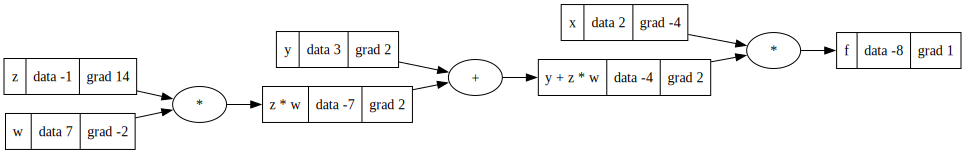

In [5]:
from graphviz import Digraph

def draw(self):
	digraph = Digraph(graph_attr={'rankdir': 'LR'})
	for v in self._toposort():
		self_id = str(id(v))
		digraph.node(
			self_id,
			'{%s | data %d | grad %d}' % (v.label, v.data, v.grad),
			shape='record'
		)
		if v._op != '':
			op_id = self_id + v._op
			digraph.node(op_id, v._op)
			digraph.edge(op_id, self_id)
			for child in v._prev:
				child_id = str(id(child))
				digraph.edge(child_id, op_id)
	return digraph

Value.draw = draw
f.backward()
f.draw()

We just created an engine that automatically performs backpropagation. By defining the operations and backward propagation mechanisms, we can create arbitrarily complex equations. This is the lego building block that we can use to make neural networks.

Note that we have done all of this from scratch. However, we will usually work with some engine that comes with a built-in backpropagation mechanism. Let's see how this is done in pytorch.

In [6]:
import torch

x = torch.tensor(2., requires_grad=True)
y = torch.tensor(3., requires_grad=True)
z = torch.tensor(-1., requires_grad=True)
w = torch.tensor(7., requires_grad=True)
f = x * (y + z * w)
f.backward()
f, x.grad, y.grad, z.grad, w.grad

(tensor(-8., grad_fn=<MulBackward0>),
 tensor(-4.),
 tensor(2.),
 tensor(14.),
 tensor(-2.))

You can see how the `Value` class we created is basically equivalent to the torch `tensor` class. There are a few differents inside, such as requiring us to provide it with floats to be able to compute gradients, and having to specify the `requires_grad` parameter to tell pytorch we want to keep track of the gradients. Other than that, both the gradients and operations are equivalent to ours.